In [6]:
import numpy as np
import pandas as pd
from pathlib import Path
from src.utils import construct_sparse_adj_mat, load_json
from src.similarity import load_similarity_matrix
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from Bio import Align

In [2]:
filepaths = OmegaConf.load('../configs/filepaths/base.yaml')

In [3]:
dataset = 'sprhea'
toc = 'v3_folded_pt_ns'
strategy = 'homology'
metric = 'gsi'


reactions = load_json(Path(filepaths.data) / dataset / (toc + ".json"))
adj, idx_sample, idx_feature = construct_sparse_adj_mat(
        Path(filepaths.data) / 'sprhea' / (toc + ".csv")
    )

reactions = {k: v for k, v in reactions.items() if k in idx_feature.values()}

split_dir = Path(filepaths.scratch) / f"{dataset}_{toc}/{strategy}/3fold"

train_val = []
for i in range(3):
    train_val.append(
        pd.read_parquet(split_dir / f"train_val_{i}.parquet")
    )
test = pd.read_parquet(split_dir / 'test.parquet')

Constructing v3_folded_pt_ns sparse adjacency matrix


In [ ]:
S = load_similarity_matrix(
    Path(filepaths.results) / "similarity_matrices", 
    dataset,
    toc,
    metric,
)

S = S.astype(np.float16)

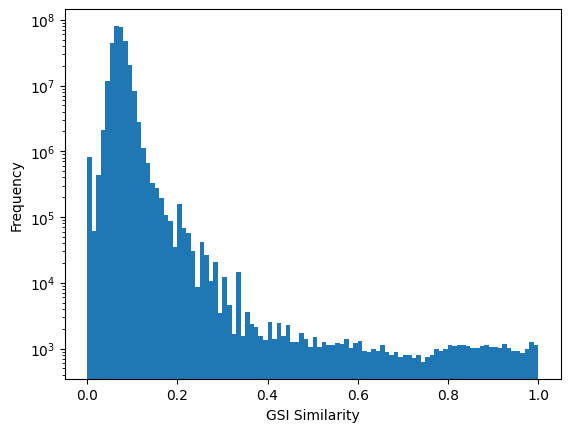

In [14]:
sims = S[np.triu_indices_from(S, k=1)]
plt.hist(sims, bins=100)
plt.yscale('log')
plt.ylabel('Frequency')
plt.xlabel(f"{metric.upper()} Similarity")
plt.savefig(Path(filepaths.artifacts) / 'figures' / 'methods' / f"{dataset}_{toc}_{strategy}_split_{metric}_similarity_hist.svg", format='svg')
plt.show()

In [15]:
train_val[0].head()

,protein_idx,reaction_idx,pid,rid,protein_embedding,smarts,reaction_center,y
0,14597,4949,Q4AEH5,3465,"[-0.19151253, 0.22544405, 0.006724517, 0.01276...",NC(CCC(=O)NC(CSSCC(NC(=O)CCC(N)C(=O)O)C(=O)NCC...,"[[[9, 10], [0], [0]], [[9], [9], [0, 1]]]",1
1,22499,3152,P19791,446,"[-0.038668983, 0.33085075, -0.18529698, 0.0166...",*OC1C(CO)OC(*)C1O.*C1OC(COP(*)(=O)O)C(OP(=O)(O...,"[[[5], [14, 12]], [[0], [5, 6]]]",1
2,3126,341,Q39086,210,"[-0.057455827, 0.04223725, -0.05662363, 0.0197...",Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O)C(O)C1...,"[[[21], [8, 9]], [[8], [22, 23]]]",1
3,3126,342,Q39086,85,"[-0.057455827, 0.04223725, -0.05662363, 0.0197...",Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O)C(O)C1...,"[[[21], [4, 5]], [[4], [22, 23]]]",1
4,21300,6068,Q5FW37,56,"[0.007033832, 0.16739662, 0.09198507, -0.00344...",CSCCC(=O)C(=O)COP(=O)(O)O.O>>CSCC(O)C(O)C(=O)C...,"[[[3, 4, 5], [0]], [[3, 4, 5, 6]]]",1


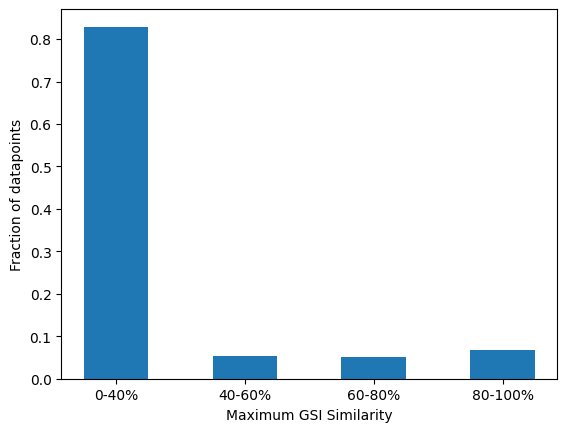

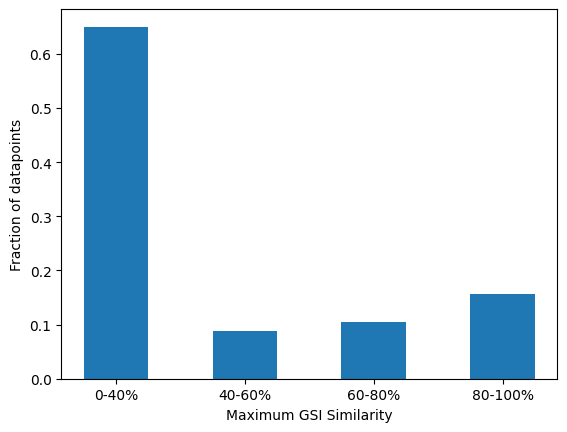

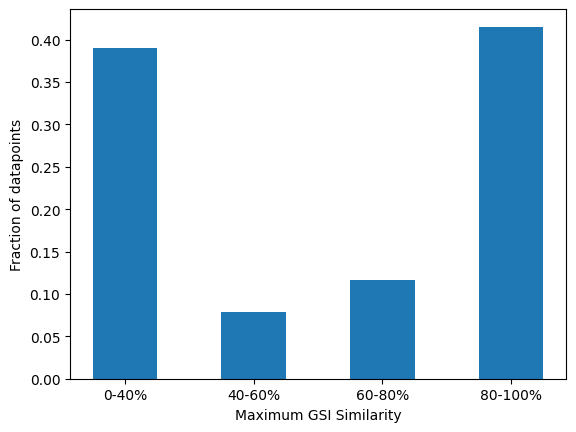

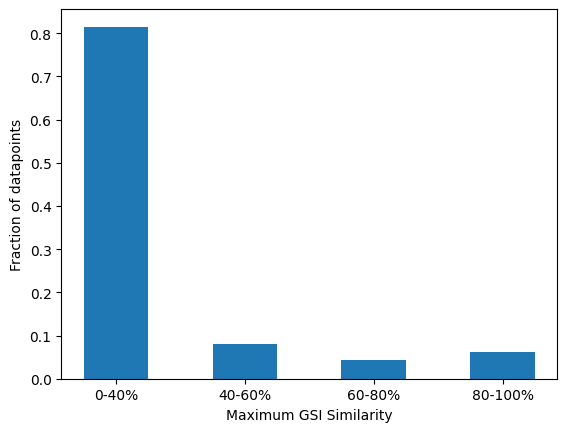

In [16]:
if strategy == 'rcmcs':
    key = 'reaction_idx'
elif strategy == 'homology':
    key = 'protein_idx'

thresholds = [1.0, 0.8, 0.6, 0.4]
thresholds = sorted(thresholds)
xticklabels = [f"0-{thresholds[0]*100:.0f}%"] + [f"{thresholds[j]*100:.0f}-{thresholds[j+1]*100:.0f}%" for j in range(len(thresholds) - 1)]

for i, val in enumerate(train_val):
    val_idx = list(set(val[key]))
    train = pd.concat([train_val[j] for j in range(3) if j != i])
    train_idx = list(set(train[key]))
    max_sims = S[:, val_idx][train_idx].max(axis=0)
    cdf = []
    for j, th in enumerate(thresholds):
        if j == 0:
            in_range = len(np.argwhere(max_sims <= th))
        else:
            less_than_th = len(np.argwhere(max_sims <= th))
            less_than_prev = len(np.argwhere(max_sims <= thresholds[j - 1]))
            in_range = less_than_th - less_than_prev
        
        cdf.append(in_range / len(max_sims))

    plt.bar(thresholds, cdf, width=0.1)
    plt.xticks(thresholds, xticklabels)
    plt.ylabel('Fraction of datapoints')
    plt.xlabel(f"Maximum {metric.upper()} Similarity")
    plt.savefig(Path(filepaths.artifacts) / 'figures' / 'methods' / f"{dataset}_{toc}_{strategy}_split_{metric}_train_val_{i}_similarity_bar_chart.svg", format='svg')
    plt.show()

val_idx = list(set(test[key]))
train = pd.concat(train_val)
train_idx = list(set(train[key]))
max_sims = S[:, val_idx][train_idx].max(axis=0)
cdf = []
for j, th in enumerate(thresholds):
    if j == 0:
        in_range = len(np.argwhere(max_sims <= th))
    else:
        less_than_th = len(np.argwhere(max_sims <= th))
        less_than_prev = len(np.argwhere(max_sims <= thresholds[j - 1]))
        in_range = less_than_th - less_than_prev
    
    cdf.append(in_range / len(max_sims))

plt.bar(thresholds, cdf, width=0.1)
plt.xticks(thresholds, xticklabels)
plt.xlabel(f"Maximum {metric.upper()} Similarity")
plt.ylabel('Fraction of datapoints')
plt.savefig(Path(filepaths.artifacts) / 'figures' / 'methods' / f"{dataset}_{toc}_{strategy}_split_{metric}_test_similarity_bar_chart.svg", format='svg')
plt.show()

In [17]:
for i, elt in enumerate(train_val):
    print(f"Fold {i}")
    print("+", len(elt[elt['y'] == 1]) / len(elt))
    print("-", len(elt[elt['y'] == 0]) / len(elt))

print(f"Test")
print("+", len(test[test['y'] == 1]) / len(test))
print("-", len(test[test['y'] == 0]) / len(test))

Fold 0
+ 0.10016230135289361
- 0.8998376986471064
Fold 1
+ 0.10049664680813576
- 0.8995033531918643
Fold 2
+ 0.09872656526353024
- 0.9012734347364697
Test
+ 0.49394257703081235
- 0.5060574229691877
